# Build a `H3` grid for the San Diego region

## Infrastructure

To create a container that includes `h3` save the following on a file called `Dockerfile`:

```Dockerfile
FROM darribas/gds_dev:4.1

USER root
RUN wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | sudo apt-key add - \
 && apt-add-repository 'deb https://apt.kitware.com/ubuntu/ bionic main' \
 && apt-get update \
 && apt-get install --yes cmake
USER $NB_UID
RUN pip install h3
```

And build the container by running the following from the same folder where the file is stored:

```
docker build -t gds_h3 .
```

In [1]:
%matplotlib widget

from h3 import h3
import geopandas
import contextily as cx
import cenpy

/opt/conda/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Region to cover

In [2]:
%%time
census = cenpy.products.Decennial2010()
sd = census.from_county("San Diego, CA",
                        level="tract"
                       )

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 2.18 s, sys: 151 ms, total: 2.33 s
Wall time: 26 s


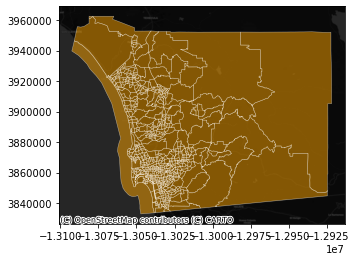

In [11]:
ax = sd.plot(alpha=0.5, 
             facecolor="orange",
             edgecolor="white",
             linewidth=0.5
            )
cx.add_basemap(ax, 
               crs=sd.crs.to_string(),
               url=cx.providers.CartoDB.DarkMatter
              )

Here's a slider to see what gets dropped based on area:

In [29]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def in_out(thr):
    tmp = sd.assign(rank=sd.geometry.area.rank())
    ax = tmp.query(f"rank < {thr}").plot(color="orange",
                                         figsize=(12, 12)
                                        )
    tmp.query(f"rank >= {thr}").plot(color="k", ax=ax)
    return plt.show()

slider = IntSlider(min=0,
                   max=sd.shape[0],
                   step=1,
                   value=0
                  )
interact(in_out, thr=slider)

interactive(children=(IntSlider(value=0, description='thr', max=628), Output()), _dom_classes=('widget-interac…

<function __main__.in_out(thr)>

## Build H3 geography

In [ ]:
%time hexs = h3.polyfill(sd.geometry[0].__geo_interface__, 5)

In [ ]:
polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

%time all_polys = geopandas.GeoSeries(list(map(polygonise, all_hexs)), \
                                      index=all_hexs, \
                                      crs="EPSG:4326"
                                     )

## Write out to `GPKG`